<h1>DDPM on MNIST: Step-by-Step Implementation</h1>

<p>This notebook implements <strong>Denoising Diffusion Probabilistic Models (DDPM)</strong> on the MNIST dataset.</p>

<h2>What is DDPM?</h2>

<p>DDPM is a generative model that learns to create images through a two-stage process:</p>

<ol>
    <li><strong>Forward Diffusion Process</strong>: Gradually adds Gaussian noise to real images over T timesteps until they become pure noise</li>
    <li><strong>Reverse Denoising Process</strong>: Learns to remove noise step-by-step, starting from random noise and generating realistic images</li>
</ol>

<h2>What We'll Do:</h2>

<ol>
    <li>Install required dependencies</li>
    <li>Import necessary libraries and implement core utilities</li>
    <li>Build the DenoiseDiffusion class (forward and reverse processes)</li>
    <li>Implement the U-Net architecture for noise prediction</li>
    <li>Set up training configuration and data loading</li>
    <li>Train the model on MNIST</li>
    <li>Generate new samples and visualize the denoising process</li>
</ol>

<h2>Key Concepts:</h2>

<ul>
    <li><strong>q(x<sub>t</sub>|x<sub>0</sub>)</strong>: Forward diffusion - how to add noise to images</li>
    <li><strong>p<sub>θ</sub>(x<sub>t-1</sub>|x<sub>t</sub>)</strong>: Reverse process - how to denoise images</li>
    <li><strong>ε<sub>θ</sub></strong>: Neural network that predicts the noise added at each step</li>
    <li><strong>U-Net</strong>: The architecture used to implement ε<sub>θ</sub></li>
</ul>


## Cell 1: Install Dependencies


We need labml-nn, which provides the DDPM implementation utilities and training frameworks.

In [7]:
!pip install labml-nn --quiet

In [8]:
import labml_nn
print("labml-nn installed successfully!")

labml-nn installed successfully!



## Cell 2: Import Core Libraries and Utility Function

Here we import:
- PyTorch for deep learning operations
- torch.nn.functional for loss functions
- The gather utility function from labml-nn

The gather() function is a helper that extracts values from tensors based on timestep indices and reshapes them for broadcasting with image tensors.

In [9]:
from typing import Tuple, Optional

import torch
import torch.nn.functional as F
import torch.utils.data
from torch import nn

from labml_nn.diffusion.ddpm.utils import gather



## Cell 3: Define gather Utility Function

This function extracts constants (like α_t or β_t) for specific timesteps and reshapes them to match image dimensions.

Parameters:
- consts: Tensor of constants for all timesteps (shape: [T])
- t: Tensor of timestep indices (shape: [batch_size])

Returns:
- Reshaped tensor (shape: [batch_size, 1, 1, 1]) ready for broadcasting

In [10]:
import torch.utils.data


def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

## Cell 4: DenoiseDiffusion Class

This class implements the complete DDPM algorithm:

1. __init__: Initializes the diffusion parameters
   - Creates linear variance schedule β_1 to β_T
   - Computes α_t = 1 - β_t and ᾱ_t = ∏α_s

2. q_xt_x0: Computes forward diffusion distribution q(x_t|x_0)
   - Returns mean: √ᾱ_t * x_0
   - Returns variance: 1 - ᾱ_t

3. q_sample: Samples from the forward diffusion process
   - Adds noise to x_0 to get x_t

4. p_sample: Samples from the reverse process p_θ(x_{t-1}|x_t)
   - Uses the trained model to predict and remove noise

5. loss: Computes the simplified training loss
   - MSE between true noise and predicted noise

In [11]:
class DenoiseDiffusion:
    """
    ## Denoise Diffusion
    """

    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        """
        * `eps_model` is $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$ model
        * `n_steps` is $t$
        * `device` is the device to place constants on
        """
        super().__init__()
        self.eps_model = eps_model

        # Create $\beta_1, \dots, \beta_T$ linearly increasing variance schedule
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)

        # $\alpha_t = 1 - \beta_t$
        self.alpha = 1. - self.beta
        # $\bar\alpha_t = \prod_{s=1}^t \alpha_s$
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        # $T$
        self.n_steps = n_steps
        # $\sigma^2 = \beta$
        self.sigma2 = self.beta

    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        #### Get $q(x_t|x_0)$ distribution

        \begin{align}
        q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
        \end{align}
        """

        # [gather](utils.html) $\alpha_t$ and compute $\sqrt{\bar\alpha_t} x_0$
        mean = gather(self.alpha_bar, t) ** 0.5 * x0
        # $(1-\bar\alpha_t) \mathbf{I}$
        var = 1 - gather(self.alpha_bar, t)
        #
        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        """
        #### Sample from $q(x_t|x_0)$

        \begin{align}
        q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
        \end{align}
        """

        # $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
        if eps is None:
            eps = torch.randn_like(x0)

        # get $q(x_t|x_0)$
        mean, var = self.q_xt_x0(x0, t)
        # Sample from $q(x_t|x_0)$
        return mean + (var ** 0.5) * eps

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        """
        #### Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$

        \begin{align}
        \textcolor{lightgreen}{p_\theta}(x_{t-1} | x_t) &= \mathcal{N}\big(x_{t-1};
        \textcolor{lightgreen}{\mu_\theta}(x_t, t), \sigma_t^2 \mathbf{I} \big) \\
        \textcolor{lightgreen}{\mu_\theta}(x_t, t)
          &= \frac{1}{\sqrt{\alpha_t}} \Big(x_t -
            \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)
        \end{align}
        """

        # $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$
        eps_theta = self.eps_model(xt, t)
        # [gather](utils.html) $\bar\alpha_t$
        alpha_bar = gather(self.alpha_bar, t)
        # $\alpha_t$
        alpha = gather(self.alpha, t)
        # $\frac{\beta}{\sqrt{1-\bar\alpha_t}}$
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        # $$\frac{1}{\sqrt{\alpha_t}} \Big(x_t -
        #      \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)$$
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        # $\sigma^2$
        var = gather(self.sigma2, t)

        # $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
        eps = torch.randn(xt.shape, device=xt.device)
        # Sample
        return mean + (var ** .5) * eps

    def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None):
        """
        #### Simplified Loss

        $$L_{\text{simple}}(\theta) = \mathbb{E}_{t,x_0, \epsilon} \Bigg[ \bigg\Vert
        \epsilon - \textcolor{lightgreen}{\epsilon_\theta}(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)
        \bigg\Vert^2 \Bigg]$$
        """
        # Get batch size
        batch_size = x0.shape[0]
        # Get random $t$ for each sample in the batch
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)

        # $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
        if noise is None:
            noise = torch.randn_like(x0)

        # Sample $x_t$ for $q(x_t|x_0)$
        xt = self.q_sample(x0, t, eps=noise)
        # Get $\textcolor{lightgreen}{\epsilon_\theta}(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)$
        eps_theta = self.eps_model(xt, t)

        # MSE loss
        return F.mse_loss(noise, eps_theta)


<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:66: SyntaxWarning: invalid escape sequence '\m'
<>:97: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:66: SyntaxWarning: invalid escape sequence '\m'
<>:97: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-922548138.py:8: SyntaxWarning: invalid escape sequence '\e'
  * `eps_model` is $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$ model
/tmp/ipython-input-922548138.py:32: SyntaxWarning: invalid escape sequence '\m'
  q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
/tmp/ipython-input-922548138.py:48: SyntaxWarning: invalid escape sequence '\m'
  q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \


## Cell 5: U-Net Architecture Components

Implementing the building blocks for the U-Net noise prediction model:

1. Swish: Activation function (x · σ(x))
2. TimeEmbedding: Embeds timestep information using sinusoidal encoding
3. ResidualBlock: Residual block with group normalization and time conditioning
4. AttentionBlock: Self-attention mechanism for capturing long-range dependencies
5. DownBlock/UpBlock: Combines residual and attention blocks for encoder/decoder
6. MiddleBlock: Bottleneck layer with attention
7. Upsample/Downsample: Resolution changing operations
8. UNet: Complete U-Net architecture that predicts noise ε_θ(x_t, t)

The U-Net takes noisy image x_t and timestep t as input, and outputs the predicted noise.

In [12]:
import math
from typing import Optional, Tuple, Union, List

import torch
from torch import nn


class Swish(nn.Module):  # Changed from Module to nn.Module
    r"""
    ### Swish activation function

    $$x \cdot \sigma(x)$$
    """

    def forward(self, x):
        return x * torch.sigmoid(x)


class TimeEmbedding(nn.Module):
    r"""
    ### Embeddings for $t$
    """

    def __init__(self, n_channels: int):
        super().__init__()
        self.n_channels = n_channels
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        self.act = Swish()
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)
        return emb


class ResidualBlock(nn.Module):  # Changed from Module to nn.Module
    r"""
    ### Residual block
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int,
                 n_groups: int = 32, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()
        self.time_emb = nn.Linear(time_channels, out_channels)
        self.time_act = Swish()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        h = self.conv1(self.act1(self.norm1(x)))
        h += self.time_emb(self.time_act(t))[:, :, None, None]
        h = self.conv2(self.dropout(self.act2(self.norm2(h))))
        return h + self.shortcut(x)


class AttentionBlock(nn.Module):  # Changed from Module to nn.Module
    r"""
    ### Attention block
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        super().__init__()
        if d_k is None:
            d_k = n_channels
        self.norm = nn.GroupNorm(n_groups, n_channels)
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        self.output = nn.Linear(n_heads * d_k, n_channels)
        self.scale = d_k ** -0.5
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        _ = t
        batch_size, n_channels, height, width = x.shape
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        attn = attn.softmax(dim=2)
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        res = self.output(res)
        res += x
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)
        return res


class DownBlock(nn.Module):  # Changed from Module to nn.Module
    r"""
    ### Down block
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):  # Changed from Module to nn.Module
    r"""
    ### Up block
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):  # Changed from Module to nn.Module
    r"""
    ### Middle block
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):
    r"""
    ### Scale up the feature map by $2 \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    r"""
    ### Scale down the feature map by $\frac{1}{2} \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        _ = t
        return self.conv(x)


class UNet(nn.Module):  # Changed from Module to nn.Module
    r"""
    ## U-Net
    """

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[bool]] = (False, False, True, True),
                 n_blocks: int = 2):
        super().__init__()
        n_resolutions = len(ch_mults)
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))
        self.time_emb = TimeEmbedding(n_channels * 4)

        down = []
        out_channels = in_channels = n_channels
        for i in range(n_resolutions):
            out_channels = in_channels * ch_mults[i]
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))
        self.down = nn.ModuleList(down)

        self.middle = MiddleBlock(out_channels, n_channels * 4)

        up = []
        in_channels = out_channels
        for i in reversed(range(n_resolutions)):
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            if i > 0:
                up.append(Upsample(in_channels))
        self.up = nn.ModuleList(up)

        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        t = self.time_emb(t)
        x = self.image_proj(x)
        h = [x]
        for m in self.down:
            x = m(x, t)
            h.append(x)
        x = self.middle(x, t)
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                x = m(x, t)
        return self.final(self.act(self.norm(x)))


## Cell 6: Training Configuration and Data Loading


Setting up the complete training pipeline:

1. Configs class: Manages all hyperparameters
   - Image size: 32x32
   - Diffusion steps: 1000
   - Batch size: 64
   - Learning rate: 2e-5
   - Epochs: 3

2. Dataset classes:
   - MNISTDataset: Loads and preprocesses MNIST digits
   - CelebADataset: Alternative dataset (not used here)

3. Training methods:
   - init(): Initializes model, diffusion, optimizer
   - train(): Training loop that computes loss and updates weights
   - sample(): Generates images by reverse diffusion
   - run(): Main training loop

The model will train for 3 epochs on MNIST. For better results, increase the number of epochs.

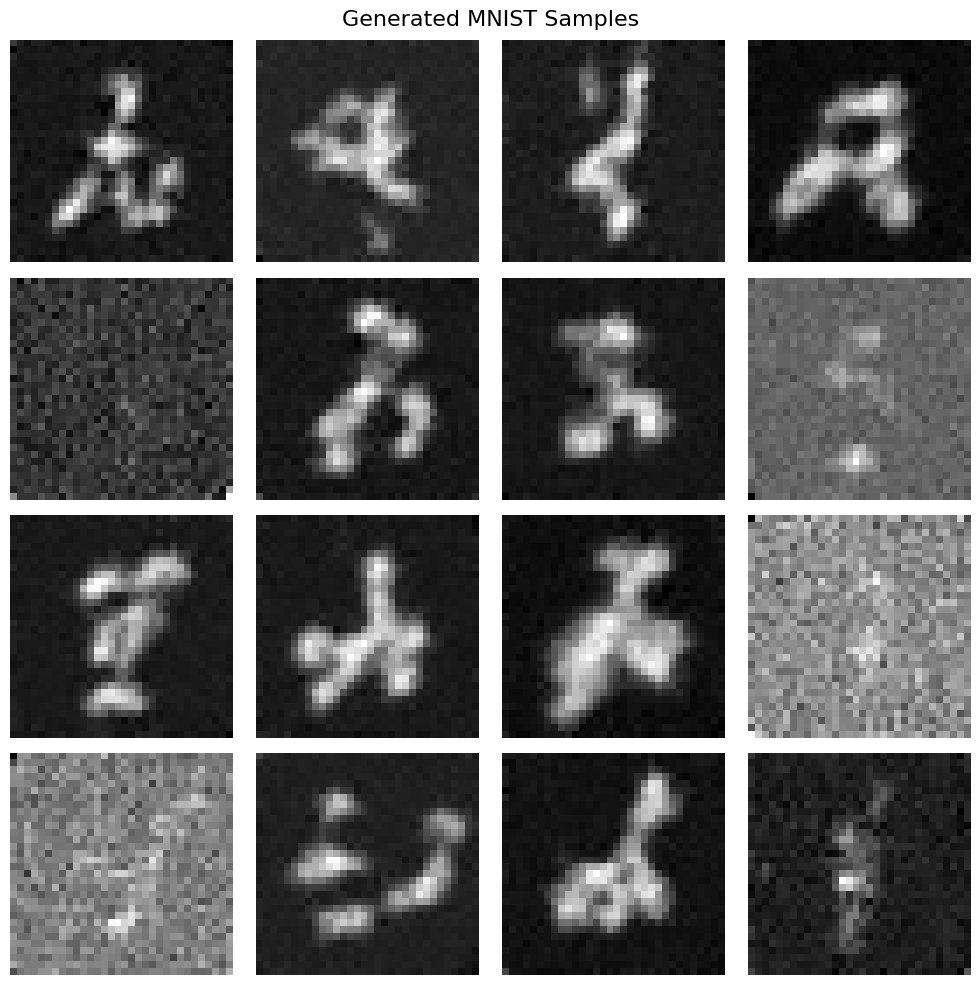

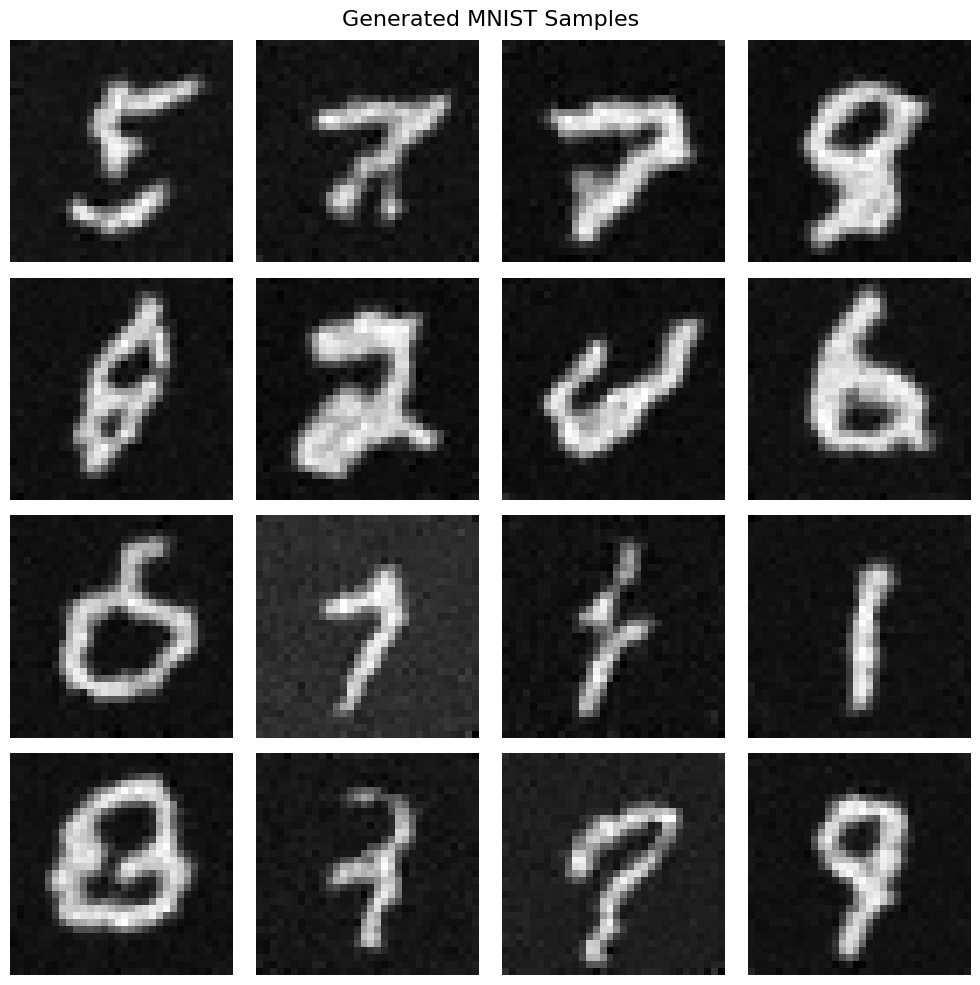

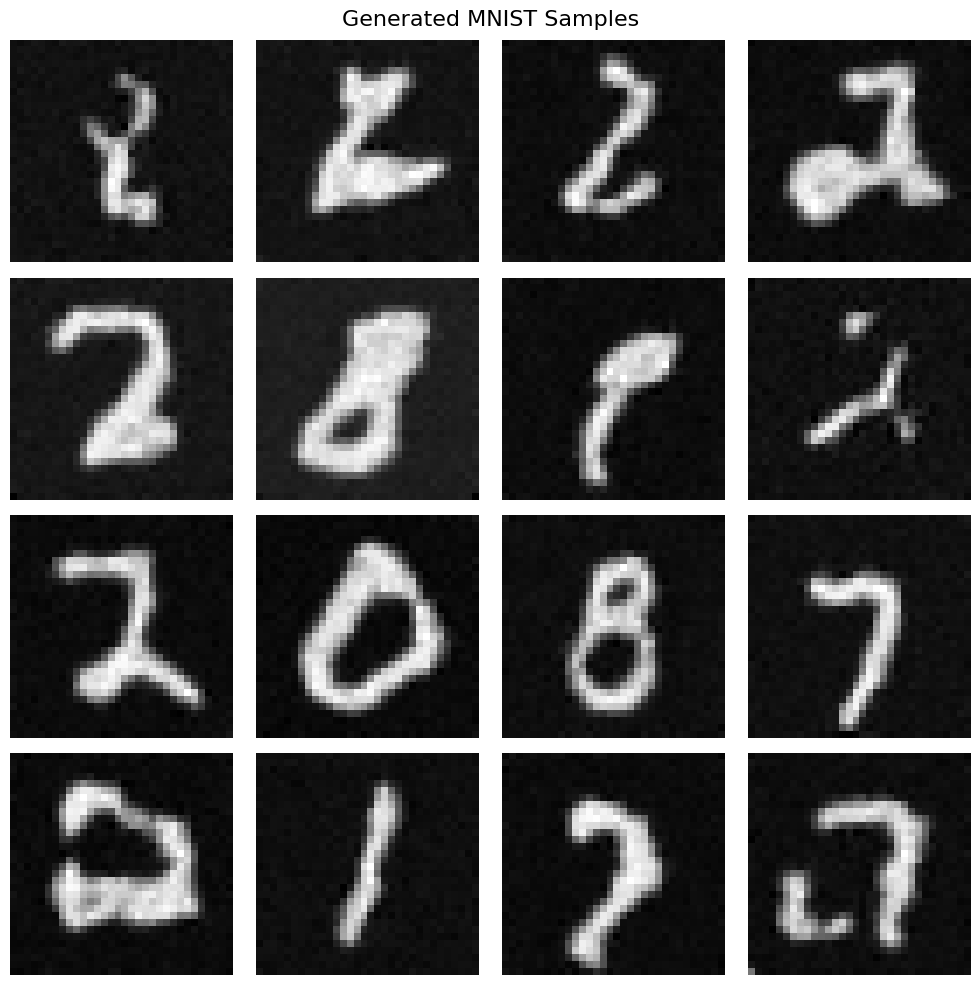

In [13]:
from typing import List

import torch
import torch.utils.data
import torchvision
from PIL import Image

from labml import tracker, experiment, monit
from labml.configs import BaseConfigs, option
from labml_nn.diffusion.ddpm import DenoiseDiffusion
from labml_nn.diffusion.ddpm.unet import UNet


class Configs(BaseConfigs):
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    eps_model: UNet
    diffusion: DenoiseDiffusion

    image_channels: int = 3
    image_size: int = 32
    n_channels: int = 64
    channel_multipliers: List[int] = [1, 2, 2, 4]
    is_attention: List[int] = [False, False, False, True]

    n_steps: int = 1_000
    batch_size: int = 64
    n_samples: int = 16
    learning_rate: float = 2e-5

    epochs: int = 100

    dataset: torch.utils.data.Dataset
    data_loader: torch.utils.data.DataLoader

    optimizer: torch.optim.Adam

    def init(self):
        self.eps_model = UNet(
            image_channels=self.image_channels,
            n_channels=self.n_channels,
            ch_mults=self.channel_multipliers,
            is_attn=self.is_attention,
        ).to(self.device)

        self.diffusion = DenoiseDiffusion(
            eps_model=self.eps_model,
            n_steps=self.n_steps,
            device=self.device,
        )

        self.data_loader = torch.utils.data.DataLoader(self.dataset, self.batch_size, shuffle=True, pin_memory=True)
        self.optimizer = torch.optim.Adam(self.eps_model.parameters(), lr=self.learning_rate)


    def sample(self):
      import matplotlib.pyplot as plt

      with torch.no_grad():
          x = torch.randn([self.n_samples, self.image_channels, self.image_size, self.image_size],
                          device=self.device)
          for t_ in monit.iterate('Sample', self.n_steps):
              t = self.n_steps - t_ - 1
              x = self.diffusion.p_sample(x, x.new_full((self.n_samples,), t, dtype=torch.long))

          # Save to tracker (original behavior)
          tracker.save('sample', x)

          # ALSO display images in notebook
          x_display = x.cpu()
          fig, axes = plt.subplots(4, 4, figsize=(10, 10))
          for i, ax in enumerate(axes.flat):
              if i < self.n_samples:
                  img = x_display[i].squeeze()
                  ax.imshow(img, cmap='gray')
                  ax.axis('off')
          plt.suptitle('Generated MNIST Samples', fontsize=16)
          plt.tight_layout()
          plt.show()

    def train(self):
        for data in monit.iterate('Train', self.data_loader):
            tracker.add_global_step()
            data = data.to(self.device)
            self.optimizer.zero_grad()
            loss = self.diffusion.loss(data)
            loss.backward()
            self.optimizer.step()
            tracker.save('loss', loss)

    def run(self):
        for _ in monit.loop(self.epochs):
            self.train()
            self.sample()
            tracker.new_line()
            torch.save(self.eps_model.state_dict(), f'checkpoint_epoch_{_}.pt')

class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, image_size: int):
        super().__init__()
        dataset = torchvision.datasets.CelebA(root="./data", split="train", download=True)
        self._images = dataset.data
        self._transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((image_size, image_size)),
            torchvision.transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self._images)

    def __getitem__(self, index: int):
        img = self._images[index]
        img = Image.fromarray(img.numpy()) if not isinstance(img, Image.Image) else img
        return self._transform(img)


@option(Configs.dataset, 'CelebA')
def celeb_dataset(c: Configs):
    return CelebADataset(c.image_size)


class MNISTDataset(torchvision.datasets.MNIST):
    def __init__(self, image_size):
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(image_size),
            torchvision.transforms.ToTensor(),
        ])
        super().__init__(root="./data", train=True, download=True, transform=transform)

    def __getitem__(self, item):
        return super().__getitem__(item)[0]


@option(Configs.dataset, 'MNIST')
def mnist_dataset(c: Configs):
    return MNISTDataset(c.image_size)


def main():
    experiment.create(name='diffuse_colab', writers={'screen'})
    configs = Configs()

    experiment.configs(configs, {
        'dataset': 'MNIST',
        'image_channels': 1,
        'epochs': 3,
    })

    configs.init()

    with experiment.start():
        configs.run()


if __name__ == '__main__':
    main()



## Cell 7: Sampler Class Definition

This class provides utilities for generating images from the trained diffusion model.

Key Components:

1. Initialization (__init__):
   - Stores the diffusion model and parameters
   - Precomputes coefficients for the reverse diffusion process
   - Sets up device and image specifications

2. Generation Methods:
   - sample(): Generates multiple images from random noise
   - sample_animation(): Creates a video of the step-by-step denoising process
   - _sample_x0(): Core sampling function that performs reverse diffusion

3. Interpolation Methods:
   - interpolate(): Blends two images in latent space
   - interpolate_animate(): Creates interpolation videos

4. Helper Methods:
   - p_sample(): Performs one reverse diffusion step
   - p_x0(): Estimates the clean image from noisy image
   - show_image(): Displays images
   - make_video(): Creates video from frames

This class encapsulates all the logic needed to transform random noise into realistic MNIST digits using the trained model.

In [4]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image, resize

from labml import experiment, monit
from labml_nn.diffusion.ddpm import DenoiseDiffusion, gather
from labml_nn.diffusion.ddpm.experiment import Configs


class Sampler:
    """
    ## Sampler class
    """

    def __init__(self, diffusion: DenoiseDiffusion, image_channels: int, image_size: int, device: torch.device):
        """
        * `diffusion` is the `DenoiseDiffusion` instance
        * `image_channels` is the number of channels in the image
        * `image_size` is the image size
        * `device` is the device of the model
        """
        self.device = device
        self.image_size = image_size
        self.image_channels = image_channels
        self.diffusion = diffusion

        # $T$
        self.n_steps = diffusion.n_steps
        # $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$
        self.eps_model = diffusion.eps_model
        # $\beta_t$
        self.beta = diffusion.beta
        # $\alpha_t$
        self.alpha = diffusion.alpha
        # $\bar\alpha_t$
        self.alpha_bar = diffusion.alpha_bar
        # $\bar\alpha_{t-1}$
        alpha_bar_tm1 = torch.cat([self.alpha_bar.new_ones((1,)), self.alpha_bar[:-1]])

        # To calculate
        #
        # \begin{align}
        # q(x_{t-1}|x_t, x_0) &= \mathcal{N} \Big(x_{t-1}; \tilde\mu_t(x_t, x_0), \tilde\beta_t \mathbf{I} \Big) \\
        # \tilde\mu_t(x_t, x_0) &= \frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1 - \bar\alpha_t}x_0
        #                          + \frac{\sqrt{\alpha_t}(1 - \bar\alpha_{t-1})}{1-\bar\alpha_t}x_t \\
        # \tilde\beta_t &= \frac{1 - \bar\alpha_{t-1}}{1 - \bar\alpha_t} \beta_t
        # \end{align}

        # $$\tilde\beta_t = \frac{1 - \bar\alpha_{t-1}}{1 - \bar\alpha_t} \beta_t$$
        self.beta_tilde = self.beta * (1 - alpha_bar_tm1) / (1 - self.alpha_bar)
        # $$\frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1 - \bar\alpha_t}$$
        self.mu_tilde_coef1 = self.beta * (alpha_bar_tm1 ** 0.5) / (1 - self.alpha_bar)
        # $$\frac{\sqrt{\alpha_t}(1 - \bar\alpha_{t-1}}{1-\bar\alpha_t}$$
        self.mu_tilde_coef2 = (self.alpha ** 0.5) * (1 - alpha_bar_tm1) / (1 - self.alpha_bar)
        # $\sigma^2 = \beta$
        self.sigma2 = self.beta

    def show_image(self, img, title=""):
        """Helper function to display an image"""
        img = img.clip(0, 1)
        img = img.cpu().numpy()
        plt.imshow(img.transpose(1, 2, 0))
        plt.title(title)
        plt.show()

    def make_video(self, frames, path="video.mp4"):
        """Helper function to create a video"""
        import imageio
        # 20 second video
        writer = imageio.get_writer(path, fps=len(frames) // 20)
        # Add each image
        for f in frames:
            f = f.clip(0, 1)
            f = to_pil_image(resize(f, [368, 368]))
            writer.append_data(np.array(f))
        #
        writer.close()

    def sample_animation(self, n_frames: int = 1000, create_video: bool = True):
        """
        #### Sample an image step-by-step using $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$

        We sample an image step-by-step using $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$ and at each step
        show the estimate
        $$x_0 \approx \hat{x}_0 = \frac{1}{\sqrt{\bar\alpha}}
         \Big( x_t - \sqrt{1 - \bar\alpha_t} \textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)$$
        """

        # $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
        xt = torch.randn([1, self.image_channels, self.image_size, self.image_size], device=self.device)

        # Interval to log $\hat{x}_0$
        interval = self.n_steps // n_frames
        # Frames for video
        frames = []
        # Sample $T$ steps
        for t_inv in monit.iterate('Denoise', self.n_steps):
            # $t$
            t_ = self.n_steps - t_inv - 1
            # $t$ in a tensor
            t = xt.new_full((1,), t_, dtype=torch.long)
            # $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$
            eps_theta = self.eps_model(xt, t)
            if t_ % interval == 0:
                # Get $\hat{x}_0$ and add to frames
                x0 = self.p_x0(xt, t, eps_theta)
                frames.append(x0[0])
                if not create_video:
                    self.show_image(x0[0], f"{t_}")
            # Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
            xt = self.p_sample(xt, t, eps_theta)

        # Make video
        if create_video:
            self.make_video(frames)

    def interpolate(self, x1: torch.Tensor, x2: torch.Tensor, lambda_: float, t_: int = 100):
        """
        #### Interpolate two images $x_0$ and $x'_0$

        We get $x_t \sim q(x_t|x_0)$ and $x'_t \sim q(x'_t|x_0)$.

        Then interpolate to
         $$\bar{x}_t = (1 - \lambda)x_t + \lambda x'_0$$

        Then get
         $$\bar{x}_0 \sim \textcolor{lightgreen}{p_\theta}(x_0|\bar{x}_t)$$

        * `x1` is $x_0$
        * `x2` is $x'_0$
        * `lambda_` is $\lambda$
        * `t_` is $t$
        """

        # Number of samples
        n_samples = x1.shape[0]
        # $t$ tensor
        t = torch.full((n_samples,), t_, device=self.device)
        # $$\bar{x}_t = (1 - \lambda)x_t + \lambda x'_0$$
        xt = (1 - lambda_) * self.diffusion.q_sample(x1, t) + lambda_ * self.diffusion.q_sample(x2, t)

        # $$\bar{x}_0 \sim \textcolor{lightgreen}{p_\theta}(x_0|\bar{x}_t)$$
        return self._sample_x0(xt, t_)

    def interpolate_animate(self, x1: torch.Tensor, x2: torch.Tensor, n_frames: int = 100, t_: int = 100,
                            create_video=True):
        """
        #### Interpolate two images $x_0$ and $x'_0$ and make a video

        * `x1` is $x_0$
        * `x2` is $x'_0$
        * `n_frames` is the number of frames for the image
        * `t_` is $t$
        * `create_video` specifies whether to make a video or to show each frame
        """

        # Show original images
        self.show_image(x1, "x1")
        self.show_image(x2, "x2")
        # Add batch dimension
        x1 = x1[None, :, :, :]
        x2 = x2[None, :, :, :]
        # $t$ tensor
        t = torch.full((1,), t_, device=self.device)
        # $x_t \sim q(x_t|x_0)$
        x1t = self.diffusion.q_sample(x1, t)
        # $x'_t \sim q(x'_t|x_0)$
        x2t = self.diffusion.q_sample(x2, t)

        frames = []
        # Get frames with different $\lambda$
        for i in monit.iterate('Interpolate', n_frames + 1, is_children_silent=True):
            # $\lambda$
            lambda_ = i / n_frames
            # $$\bar{x}_t = (1 - \lambda)x_t + \lambda x'_0$$
            xt = (1 - lambda_) * x1t + lambda_ * x2t
            # $$\bar{x}_0 \sim \textcolor{lightgreen}{p_\theta}(x_0|\bar{x}_t)$$
            x0 = self._sample_x0(xt, t_)
            # Add to frames
            frames.append(x0[0])
            # Show frame
            if not create_video:
                self.show_image(x0[0], f"{lambda_ :.2f}")

        # Make video
        if create_video:
            self.make_video(frames)

    def _sample_x0(self, xt: torch.Tensor, n_steps: int):
        """
        #### Sample an image using $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$

        * `xt` is $x_t$
        * `n_steps` is $t$
        """

        # Number of sampels
        n_samples = xt.shape[0]
        # Iterate until $t$ steps
        for t_ in monit.iterate('Denoise', n_steps):
            t = n_steps - t_ - 1
            # Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
            xt = self.diffusion.p_sample(xt, xt.new_full((n_samples,), t, dtype=torch.long))

        # Return $x_0$
        return xt

    def sample(self, n_samples: int = 16):
        """
        #### Generate images
        """
        # $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
        xt = torch.randn([n_samples, self.image_channels, self.image_size, self.image_size], device=self.device)

        # $$x_0 \sim \textcolor{lightgreen}{p_\theta}(x_0|x_t)$$
        x0 = self._sample_x0(xt, self.n_steps)

        # Show images
        for i in range(n_samples):
            self.show_image(x0[i])

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor, eps_theta: torch.Tensor):
        """
        #### Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$

        \begin{align}
        \textcolor{lightgreen}{p_\theta}(x_{t-1} | x_t) &= \mathcal{N}\big(x_{t-1};
        \textcolor{lightgreen}{\mu_\theta}(x_t, t), \sigma_t^2 \mathbf{I} \big) \\
        \textcolor{lightgreen}{\mu_\theta}(x_t, t)
          &= \frac{1}{\sqrt{\alpha_t}} \Big(x_t -
            \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)
        \end{align}
        """
        # [gather](utils.html) $\bar\alpha_t$
        alpha_bar = gather(self.alpha_bar, t)
        # $\alpha_t$
        alpha = gather(self.alpha, t)
        # $\frac{\beta}{\sqrt{1-\bar\alpha_t}}$
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        # $$\frac{1}{\sqrt{\alpha_t}} \Big(x_t -
        #      \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)$$
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        # $\sigma^2$
        var = gather(self.sigma2, t)

        # $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
        eps = torch.randn(xt.shape, device=xt.device)
        # Sample
        return mean + (var ** .5) * eps

    def p_x0(self, xt: torch.Tensor, t: torch.Tensor, eps: torch.Tensor):
        """
        #### Estimate $x_0$

        $$x_0 \approx \hat{x}_0 = \frac{1}{\sqrt{\bar\alpha}}
         \Big( x_t - \sqrt{1 - \bar\alpha_t} \textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)$$
        """
        # [gather](utils.html) $\bar\alpha_t$
        alpha_bar = gather(self.alpha_bar, t)

        # $$x_0 \approx \hat{x}_0 = \frac{1}{\sqrt{\bar\alpha}}
        #  \Big( x_t - \sqrt{1 - \bar\alpha_t} \textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)$$
        return (xt - (1 - alpha_bar) ** 0.5 * eps) / (alpha_bar ** 0.5)


<>:86: SyntaxWarning: invalid escape sequence '\h'
<>:122: SyntaxWarning: invalid escape sequence '\s'
<>:228: SyntaxWarning: invalid escape sequence '\m'
<>:256: SyntaxWarning: invalid escape sequence '\h'
<>:86: SyntaxWarning: invalid escape sequence '\h'
<>:122: SyntaxWarning: invalid escape sequence '\s'
<>:228: SyntaxWarning: invalid escape sequence '\m'
<>:256: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-944372724.py:86: SyntaxWarning: invalid escape sequence '\h'
  $$x_0 \approx \hat{x}_0 = \frac{1}{\sqrt{\bar\alpha}}
/tmp/ipython-input-944372724.py:122: SyntaxWarning: invalid escape sequence '\s'
  We get $x_t \sim q(x_t|x_0)$ and $x'_t \sim q(x'_t|x_0)$.
/tmp/ipython-input-944372724.py:228: SyntaxWarning: invalid escape sequence '\m'
  \textcolor{lightgreen}{p_\theta}(x_{t-1} | x_t) &= \mathcal{N}\big(x_{t-1};
/tmp/ipython-input-944372724.py:256: SyntaxWarning: invalid escape sequence '\h'
  $$x_0 \approx \hat{x}_0 = \frac{1}{\sqrt{\bar\alpha}}


## Cell 8: Load Trained Model and Initialize Sampler

This cell prepares your trained DDPM model for generating new MNIST digit images.

What happens step-by-step:

1. Create Configuration Instance:
   - Creates a new Configs object to hold all model settings

2. Set Model Parameters:
   - Configures the model with the same settings used during training
   - image_channels=1: Grayscale images (MNIST is black and white)
   - image_size=32: Images are 32x32 pixels
   - n_channels=64: Base number of channels in the U-Net
   - channel_multipliers=[1,2,2,4]: How channels scale at each resolution
   - is_attention=[False,False,False,True]: Where to use attention mechanisms
   - n_steps=1000: Number of diffusion/denoising steps

3. Initialize Model Architecture:
   - Builds the U-Net neural network structure
   - Creates the diffusion process object
   - Sets up everything but doesn't load trained weights yet

4. Load Checkpoint File:
   - Reads the saved model from training (checkpoint_epoch_2.pt)
   - This file contains the trained weights after 3 epochs
   - map_location ensures it loads to the correct device (GPU/CPU)

5. Verify and Load Weights:
   - Checks the checkpoint format (dict or direct state)
   - Loads the trained parameters into the model
   - Shows which epoch the weights came from

6. Set to Evaluation Mode:
   - Switches the model from training to generation mode
   - Disables dropout and batch normalization training behavior

7. Create Sampler Instance:
   - Wraps the loaded model in a Sampler utility class
   - Provides convenient methods for generating images and videos
   - Ready to transform random noise into MNIST digits

After this cell runs, the 'sampler' variable contains your fully trained model and is ready to generate new digit images from scratch.

In [19]:
"""Load Trained Model and Initialize Sampler"""

# Create configs instance
configs = Configs()

# Set configuration (same as training)
configs.dataset = MNISTDataset(32)
configs.image_channels = 1
configs.image_size = 32
configs.n_channels = 64
configs.channel_multipliers = [1, 2, 2, 4]
configs.is_attention = [False, False, False, True]
configs.n_steps = 1_000

# Initialize the model architecture
configs.init()

# Load the checkpoint - it's a dict with 'model_state_dict' key
checkpoint = torch.load('/content/checkpoint_epoch_2.pt', map_location=configs.device)

# Check what's in it
print(f"Checkpoint type: {type(checkpoint)}")
print(f"Checkpoint keys: {list(checkpoint.keys()) if isinstance(checkpoint, dict) else 'N/A'}")

# Load the model weights
if isinstance(checkpoint, dict):
    if 'model_state_dict' in checkpoint:
        configs.eps_model.load_state_dict(checkpoint['model_state_dict'])
        print(f" Loaded model from epoch {checkpoint.get('epoch', '?')}")
    else:
        # Try loading as direct state dict
        configs.eps_model.load_state_dict(checkpoint)
        print(" Loaded model (direct state dict)")
else:
    configs.eps_model.load_state_dict(checkpoint)
    print(" Loaded model")

configs.eps_model.eval()  # Set to evaluation mode

# Create sampler
sampler = Sampler(
    diffusion=configs.diffusion,
    image_channels=configs.image_channels,
    image_size=configs.image_size,
    device=configs.device
)

print(" Model loaded successfully! Sampler ready to generate images!")

Checkpoint type: <class 'collections.OrderedDict'>
Checkpoint keys: ['image_proj.weight', 'image_proj.bias', 'time_emb.lin1.weight', 'time_emb.lin1.bias', 'time_emb.lin2.weight', 'time_emb.lin2.bias', 'down.0.res.norm1.weight', 'down.0.res.norm1.bias', 'down.0.res.conv1.weight', 'down.0.res.conv1.bias', 'down.0.res.norm2.weight', 'down.0.res.norm2.bias', 'down.0.res.conv2.weight', 'down.0.res.conv2.bias', 'down.0.res.time_emb.weight', 'down.0.res.time_emb.bias', 'down.1.res.norm1.weight', 'down.1.res.norm1.bias', 'down.1.res.conv1.weight', 'down.1.res.conv1.bias', 'down.1.res.norm2.weight', 'down.1.res.norm2.bias', 'down.1.res.conv2.weight', 'down.1.res.conv2.bias', 'down.1.res.time_emb.weight', 'down.1.res.time_emb.bias', 'down.2.conv.weight', 'down.2.conv.bias', 'down.3.res.norm1.weight', 'down.3.res.norm1.bias', 'down.3.res.conv1.weight', 'down.3.res.conv1.bias', 'down.3.res.norm2.weight', 'down.3.res.norm2.bias', 'down.3.res.conv2.weight', 'down.3.res.conv2.bias', 'down.3.res.short


## Cell 9: Generate Samples - Run 1


Using the loaded model to generate a new MNIST digit with step-by-step visualization.

What happens:
1. Starts with pure random Gaussian noise (x_T)
2. Iteratively applies reverse diffusion for 1000 steps
3. At each step, the model predicts and removes noise
4. Creates a video showing the gradual transformation
5. Displays the final generated digit

The generation process is stochastic (involves randomness), so each run produces different results.

Technical details:
- experiment.start(): Manages experiment context and logging
- torch.no_grad(): Disables gradient computation (we're generating, not training)
- sampler.sample_animation(): Performs the reverse diffusion with video output
- n_frames=100: Captures 100 frames throughout the 1000 denoising steps

Watch how the model transforms pure noise into a recognizable MNIST digit!

In [21]:
"""Generate samples - Run 1"""

with torch.no_grad():
    # Generate sample animation (or images)
    sampler.sample_animation(n_frames=100, create_video=True)

    # Display video in notebook
    from IPython.display import Video, display
    display(Video("video.mp4", embed=True))

## Cell 10: Generate Samples - Run 2


Running the same generation process again to produce a different output.

Since the initial noise is randomly sampled, this run will generate a completely different digit than Run 1. This demonstrates the diversity and stochastic nature of the diffusion model.

Compare the output with Run 1 to observe how the model can generate various digits with consistent quality.

In [25]:
"""Generate samples - Run 2"""

with torch.no_grad():
    # Generate sample animation (or images)
    sampler.sample_animation(n_frames=100, create_video=True)

    # Display video in notebook
    from IPython.display import Video, display
    display(Video("video.mp4", embed=True))

## Cell 11: Generate Samples - Run 3

Third generation run to further showcase the model's diversity.

Each execution generates a unique digit, demonstrating:
- The model's ability to produce varied outputs
- Consistent generation quality across multiple runs
- The stochastic nature of the sampling process

Review all three runs (Run 1, Run 2, and Run 3) to see the range of digits the model can generate. You may see different numbers (0-9) and different styles of the same number across the runs.

In [26]:
"""Generate samples - Run 3"""

with torch.no_grad():
    # Generate sample animation (or images)
    sampler.sample_animation(n_frames=100, create_video=True)

    # Display video in notebook
    from IPython.display import Video, display
    display(Video("video.mp4", embed=True))

=> Naturally, increasing the number of training epochs will yield significantly improved generation quality and diversity. Extended training allows the model to better capture the underlying data distribution, resulting in more realistic and varied outputs.